In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/capstone/data.csv')

In [3]:
df.head(2)

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment,Length,Word_count,mean_word_length,clean_review,pos_counts
0,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49.000,True,3.2,Comedy,2016,2016-09,2016-09-16,positive,83,14,5.000000,pretty good pretty comical scene throughout gr...,"Counter({'ADV': 3, 'ADJ': 3, 'PUNCT': 3, 'NOUN..."
1,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17.000,True,4.6,Drama,2016,2016-11,2016-11-08,neutral,37,7,4.428571,bit slow unsatisfying ending,"Counter({'DET': 2, 'NOUN': 2, 'ADJ': 1, 'CCONJ..."


## BInary classification

In [4]:
df.isna().sum()

,0
rating,0
title,0
text,0
timestamp,0
verified_purchase,0
average_rating,0
categories,0
year,0
month,0
day,0


In [5]:
# Remove neutral reviews
data = df[df["rating"] != 3]

In [6]:
data = data.dropna(subset=['clean_review'])

In [7]:
data['sentiment'].value_counts()

,count
sentiment,
positive,18173
negative,3302


In [8]:
# Train-Validation-Test Split (70% Train, 15% Validation, 15% Test)
X, y = data["clean_review"], data["sentiment"]

# First, split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then, split Temp into Validation (50%) and Test (50%) → 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print dataset sizes
print(f"Train Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")

Train Set: 15032 samples
Validation Set: 3221 samples
Test Set: 3222 samples


In [9]:
data.isna().sum()

,0
rating,0
title,0
text,0
timestamp,0
verified_purchase,0
average_rating,0
categories,0
year,0
month,0
day,0


In [10]:
# Define the single pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("classifier", MultinomialNB())  # Placeholder for GridSearchCV
])

In [11]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier', MultinomialNB())])

In [12]:
# Evaluate the model
y_pred = pipeline.predict(X_val)
print("\nML Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))


ML Model Evaluation:
Accuracy: 0.8804719031356721


In [13]:
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.23      0.38       495
    positive       0.88      1.00      0.93      2726

    accuracy                           0.88      3221
   macro avg       0.91      0.62      0.65      3221
weighted avg       0.89      0.88      0.85      3221



In [14]:
# Define parameter grid
param_grid = [
    {
        #"tfidf__ngram_range": [(1,1), (1,2)],  # Unigrams & Bigrams
        "classifier": [MultinomialNB()],
        "classifier__alpha": [0.1, 0.5, 1.0]  # Smoothing parameter for Naïve Bayes
    },
    {
        #"tfidf__ngram_range": [(1,1), (1,2)],  # Unigrams & Bigrams
        "classifier": [SVC()],
        "classifier__C": [0.1, 1, 10],  # Regularization strength for SVM
        "classifier__kernel": ["linear", "rbf"]  # Kernel types
    }
]

In [15]:
# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1.0]},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'rbf']}],
             scoring='accuracy', verbose=1)

In [16]:
# Get best model
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier', SVC(C=10))])

In [17]:
# Make predictions on val set
y_pred = best_model.predict(X_val)

In [18]:
print("Accuracy on validation Set:", accuracy_score(y_val, y_pred))

Accuracy on validation Set: 0.9118286246507296


In [19]:
print("Classification Report on Test Set:\n", classification_report(y_val, y_pred))

Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.86      0.51      0.64       495
    positive       0.92      0.98      0.95      2726

    accuracy                           0.91      3221
   macro avg       0.89      0.75      0.80      3221
weighted avg       0.91      0.91      0.90      3221



### Multiclass classification

In [20]:
# Convert neutral class to positive
df['sentiment'] = df['sentiment'].replace({'neutral': 'positive'})

In [21]:
df = df.dropna(subset=['clean_review'])

In [22]:
# Train-Validation-Test Split (70% Train, 15% Validation, 15% Test)
X, y = df["clean_review"], df["sentiment"]

# First, split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then, split Temp into Validation (50%) and Test (50%) → 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print dataset sizes
print(f"Train Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")

Train Set: 16820 samples
Validation Set: 3604 samples
Test Set: 3605 samples


In [23]:
# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1.0]},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'rbf']}],
             scoring='accuracy', verbose=1)

In [24]:
# Get best model
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier', SVC(C=1, kernel='linear'))])

In [25]:
# Make predictions on test set
y_pred = best_model.predict(X_val)

In [26]:
print("Accuracy on validation Set:", accuracy_score(y_val, y_pred))

Accuracy on validation Set: 0.9003884572697003


In [27]:
print("Classification Report on Test Set:\n", classification_report(y_val, y_pred))

Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.76      0.41      0.53       495
    positive       0.91      0.98      0.94      3109

    accuracy                           0.90      3604
   macro avg       0.83      0.69      0.74      3604
weighted avg       0.89      0.90      0.89      3604



In [28]:
best_model.predict(['the lord of the rings is an excellent movie',
                     'i hated the recent movie on tv, it was so bad'])

array(['positive', 'negative'], dtype=object)

In [29]:

# # Get probabilities for predictions
# y_pred_proba = best_model.predict_proba(['the lord of the rings is an excellent movie',
#                      'i hated the recent movie on tv, it was so bad'])

# y_pred_proba                                                                                                                                                                                                                                                                               df"?QaAAAAAAAAAAAAAAAAAAA]


In [30]:
def train_and_evaluate(model_class, model_params, model_name):
    """
    Trains and evaluates a model using a pipeline with dynamic model parameters.

    :param model_class: The machine learning model class (e.g., MultinomialNB, SVC)
    :param model_params: Dictionary of parameters to initialize the model
    :param model_name: Name of the model (for printing results)
    :return: The trained pipeline
    """
    # Initialize model with dynamic parameters
    model = model_class(**model_params)

    # Create pipeline
    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer(stop_words="english", max_features=5000)),
        ("classifier", model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predict on validation data
    y_val_pred = pipeline.predict(X_val)

    # Evaluate model
    print(f"\n--- {model_name} Model Evaluation (Validation Set) ---")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    labels = np.unique(y_val)  # Dynamically get class labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix (Validation Set)")
    plt.show()

    return pipeline  # Return the trained model


--- MultinomialNB Model Evaluation (Validation Set) ---
Accuracy: 0.8720865704772475
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.08      0.14       495
    positive       0.87      1.00      0.93      3109

    accuracy                           0.87      3604
   macro avg       0.89      0.54      0.54      3604
weighted avg       0.88      0.87      0.82      3604



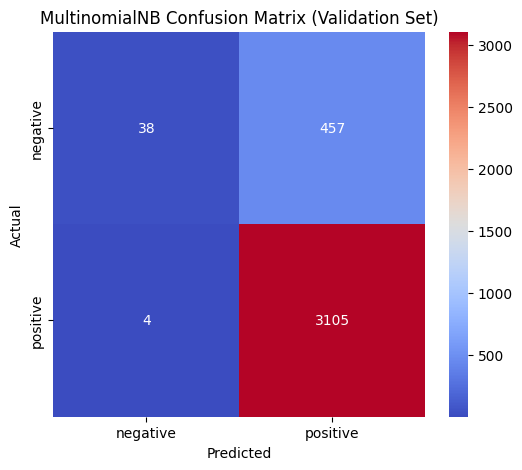

In [31]:
nb_params = {"alpha": 2.0}
nb_pipeline = train_and_evaluate(MultinomialNB, nb_params, "MultinomialNB")


--- SVM Model Evaluation (Validation Set) ---
Accuracy: 0.8515538290788013
Classification Report:
               precision    recall  f1-score   support

    negative       0.47      0.74      0.58       495
    positive       0.95      0.87      0.91      3109

    accuracy                           0.85      3604
   macro avg       0.71      0.81      0.74      3604
weighted avg       0.89      0.85      0.86      3604



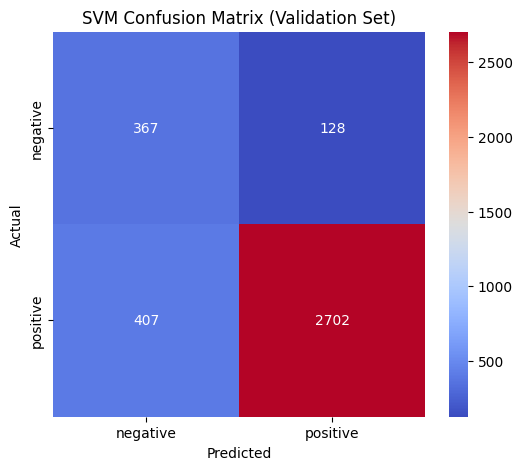

In [32]:
svm_params = {"C": 1.0, "kernel": "linear", "class_weight": "balanced"}
svm_pipeline = train_and_evaluate(SVC, svm_params, "SVM")

In [33]:
df['sentiment'].value_counts()

,count
sentiment,
positive,20727
negative,3302


In [34]:



# Print Initial Class Distribution
print("Before Handling Imbalance:")
print("Train class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))  # Unchanged
print("Test class distribution:", Counter(y_test))  # Unchanged

# Convert Text to Numerical Features (TF-IDF)
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit on train data only
X_val_tfidf = vectorizer.transform(X_val)  # Transform validation
X_test_tfidf = vectorizer.transform(X_test)  # Transform test

# Apply SMOTE Only on the Training Set (Now it's numerical)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Print New Class Distribution After SMOTE
print("\nAfter SMOTE:")
print("Resampled Train class distribution:", Counter(y_train_resampled))
print("Validation class distribution:", Counter(y_val))  # Unchanged
print("Test class distribution:", Counter(y_test))  # Unchanged

# Now Use X_train_resampled, y_train_resampled for Model Training


Before Handling Imbalance:
Train class distribution: Counter({'positive': 14509, 'negative': 2311})
Validation class distribution: Counter({'positive': 3109, 'negative': 495})
Test class distribution: Counter({'positive': 3109, 'negative': 496})

After SMOTE:
Resampled Train class distribution: Counter({'positive': 14509, 'negative': 14509})
Validation class distribution: Counter({'positive': 3109, 'negative': 495})
Test class distribution: Counter({'positive': 3109, 'negative': 496})


In [40]:
def train_and_evaluate_resampled(model_class, model_params, model_name):
    """
    Trains and evaluates a model using a pipeline with dynamic model parameters.

    :param model_class: The machine learning model class (e.g., MultinomialNB, SVC)
    :param model_params: Dictionary of parameters to initialize the model
    :param model_name: Name of the model (for printing results)
    :return: The trained pipeline
    """
    # Initialize model with parameters
    model = model_class(**model_params)

    # Create pipeline
    pipeline = Pipeline([
        ("classifier", model)
    ])

    # Train model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on validation data
    y_val_pred = pipeline.predict(X_val_tfidf)

    # Evaluate model
    print(f"\n--- {model_name} Model Evaluation (Validation Set) ---")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    labels = np.unique(y_val)  # Dynamically get class labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix (Validation Set)")
    plt.show()

    return pipeline  # Return the trained pipeline


--- MultinomialNB Model Evaluation (Validation Set) ---
Accuracy: 0.8576581576026637
Classification Report:
               precision    recall  f1-score   support

    negative       0.49      0.79      0.60       495
    positive       0.96      0.87      0.91      3109

    accuracy                           0.86      3604
   macro avg       0.73      0.83      0.76      3604
weighted avg       0.90      0.86      0.87      3604



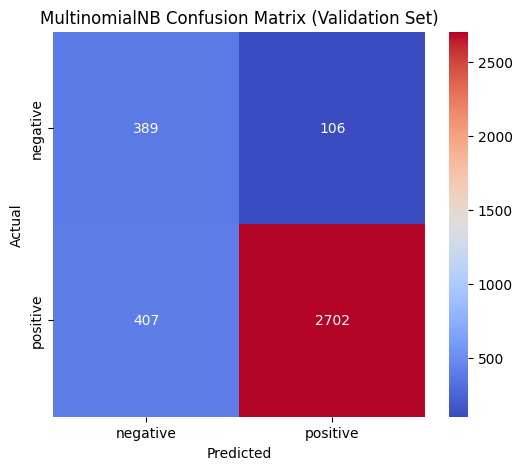

In [47]:
# Train and Evaluate MultinomialNB
nb_pipe = train_and_evaluate_resampled(MultinomialNB, {"alpha": 2.0}, "MultinomialNB")


--- SVM Model Evaluation (Validation Set) ---
Accuracy: 0.8490566037735849
Classification Report:
               precision    recall  f1-score   support

    negative       0.47      0.69      0.56       495
    positive       0.95      0.87      0.91      3109

    accuracy                           0.85      3604
   macro avg       0.71      0.78      0.73      3604
weighted avg       0.88      0.85      0.86      3604



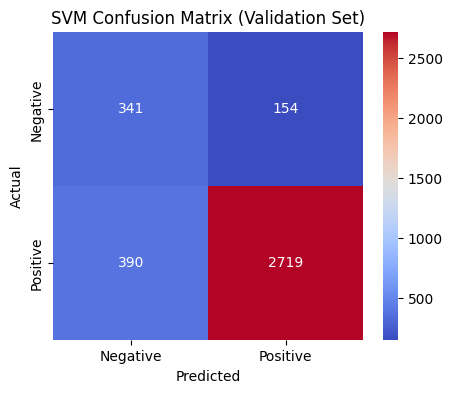

In [37]:
# Train and Evaluate SVM
svm_pipe = train_and_evaluate_resampled(SVC, {"kernel": "linear", "C": 1.0}, "SVM")

In [38]:
svm_pipe

Pipeline(steps=[('classifier', SVC(kernel='linear'))])

In [39]:
text_data = (['the lord of the rings is an excellent movie',
                     'i hated the recent movie on tv, it was so bad'])

# Transform text using the same TF-IDF vectorizer
text_tfidf = vectorizer.transform(text_data)

svm_pipe.predict(text_tfidf)

array(['positive', 'negative'], dtype=object)